In [1]:
pip install --user tqdm

In [2]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms # 이미지 변환(전처리) 기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim # 경사 하강법을 이용하여 가중치를 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os # 파일 경로에 대한 함수들을 제공
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm # 진행 상황을 가시적으로 표현해 주는데, 특히 모델의 학습 경과를 확인하고 싶을 때 사용하는 라이브러리
import random
from matplotlib import pyplot as plt

device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 파이토치는 텐서플로와 다르게 GPU를 자동으로 할당해 주지 않기 때문에 GPU 할당을 모델과 데이터에 선언해 주어야 한다. 단 이 장에서는 CPU를 사용한다.

**데이터셋 전처리(텐서 변환)**


In [3]:
class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform={
        'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }
  def __call__(self, img, phase):
    return self.data_transform[phase](img)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cat_directory=r'/content/drive/MyDrive/24-2/EURON/과제/Week7/dogs-vs-cats/Cat'
dog_directory=r'/content/drive/MyDrive/24-2/EURON/과제/Week7/dogs-vs-cats/Dog'

cat_images_filepaths=sorted([os.path.join(cat_directory, f) for f in
                             os.listdir(cat_directory)])
dog_images_filepaths=sorted([os.path.join(dog_directory, f) for f in
                             os.listdir(dog_directory)])
images_filepaths=[*cat_images_filepaths, *dog_images_filepaths] # 개와 고양이 이미지들을 합쳐서 images_filepaths에 저장
correct_images_filepaths=[i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths=correct_images_filepaths[:400] # 훈련용 400개의 이미지
val_images_filepaths=correct_images_filepaths[400:-10] # 검증용 92개의 이미지
test_images_filepaths=correct_images_filepaths[-10:] # 테스트용 10개의 이미지
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [7]:
import os
list_path=['C://', 'Temp', 'user']
folder_path=os.path.join(*list_path)
folder_path

'C://Temp/user'

예1) 시드 값을 101로 설정했을 때

In [8]:
import numpy as np

np.random.seed(101)
np.random.randint(low=1, high=10, size=10)

array([2, 7, 8, 9, 5, 9, 6, 1, 6, 9])

예2) 시드 값을 100으로 설정했을 때

In [9]:
np.random.seed(100)
np.random.randint(low=1, high=10, size=10)

array([9, 9, 4, 8, 8, 1, 5, 3, 6, 3])

In [10]:
import numpy as np

np.random.seed(101)
np.random.randint(low=1, high=10, size=10)

array([2, 7, 8, 9, 5, 9, 6, 1, 6, 9])

In [20]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
  rows=len(images_filepaths) // cols
  figure, ax=plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
  for i, image_filepath in enumerate(images_filepaths):
    image=cv2.imread(image_filepath)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    true_label=os.path.normpath(image_filepath).split(os.sep)[-2]
    predicted_label=predicted_labels[i] if predicted_labels else true_label
    color='green' if true_label==predicted_label else 'red' # 예측과 정답(레이블)이 동일하면 초록색으로 표시하고, 그렇지 않다면 빨간색으로 표시
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(predicted_label, color=color) # predicted_label을 타이틀로 사용
    ax.ravel()[i].set_axis_off()
  plt.tight_layout() # 이미지의 여백을 조정
  plt.show()

**10개의 이미지 호출**

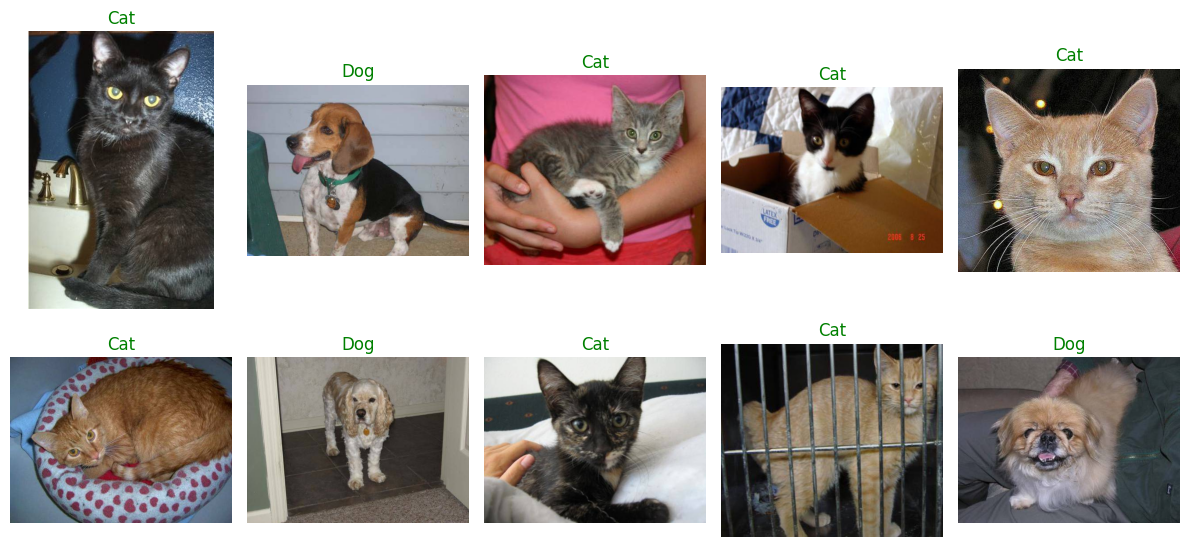

In [21]:
display_image_grid(test_images_filepaths)

⭐ 이번 예제의 목적 : 다수의 개와 고양이 이미지가 포함된 데이터에서 이들을 예측하는 것이다. 따라서 레이블(정답) 이미지에서 고양이와 개가 포함될 확률을 코드로 구현한다. 예를 들어 고양이가 있는 이미지의 레이블은 0, 개가 있는 이미지의 레이블은 1이 되도록 코드를 구현한다.

In [25]:
class DogvsCatDataset(Dataset):
  def __init__(self, file_list, transform=None, phase='train'): # 데이터셋의 전처리(데이터 변형 적용)
    self.file_list=file_list
    self.transform=transform # DogvsCatDataset 클래스를 호출할 때 transform에 대한 매개변수를 받아온다.
    self.phase=phase # 'train' 적용

  def __len__(self): # images_filepaths 데이터셋의 전체 길이를 반환
    return len(self.file_list)

  def __getitem__(self, idx):
    img_path=self.file_list[idx]
    img=Image.open(img_path)
    img_transformed=self.transform(img, self.phase)
    label=img_path.split('/')[-1].split('.')[0]
    if label=='dog':
      label=1
    elif label=='cat':
      label=0
    return img_transformed, label

**전처리에서 사용할 변수에 대한 값 정의**

In [26]:
size=224
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
batch_size=32

**훈련과 검증 용도의 데이터셋 정의** : 앞에서 정의한 `DogvsCatDataset()` 클래스를 이용하여 훈련과 검증 데이터셋을 준비하되 전처리도 함께 적용하도록 한다.

In [27]:
train_dataset=DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std),
                              phase='train') # 훈련 이미지에 train_transforms를 적용

val_dataset=DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std),
                            phase='val') # 검증 이미지에 test_transform을 적용

index=0
print(train_dataset.__getitem__(index)[0].size()) # 훈련 데이터(train_dataset.__getitem[0][0])의 크기(size()) 출력
print(train_dataset.__getitem__(index)[1]) # 훈련 데이터의 레이블 출력

torch.Size([3, 224, 224])
0


4️⃣ **데이터로더 정의** : 전처리와 함께 데이터셋을 정의했기 때문에 메모리로 불러와서 훈련을 위한 준비를 한다.

In [28]:
train_dataloader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict={'train' : train_dataloader, 'val' : val_dataloader} # 훈련 데이터셋(train_dataloader)과 검증 데이터셋(val_dataloader)를 합쳐서 표현

batch_iterator=iter(train_dataloader)
inputs, label=next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 0])


5. 모델의 네트워크를 설계하기 위한 클래스 생성

In [29]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.cnn1=nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1,
                        padding=0)
    self.relu1=nn.ReLU()
    self.maxpool1=nn.MaxPool2d(kernel_size=2)
    self.cnn2=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5,
                        stride=1, padding=0)
    self.relu2=nn.ReLU()
    self.maxpool2=nn.MaxPool2d(kernel_size=2)

    self.fc1=nn.Linear(32*53*53, 512)
    self.relu5=nn.ReLU()
    self.fc2=nn.Linear(512, 2)
    self.output=nn.Softmax(dim=1)

  def forward(self, x):
    out=self.cnn1(x)
    out=self.relu1(out)
    out=self.maxpool1(out)
    out=self.cnn2(out)
    out=self.relu2(out)
    out=self.maxpool2(out)
    out=out.view(out.size(0), -1)
    out=self.fc1(out)
    out=self.fc2(out)
    out=self.output(out)
    return out

In [30]:
model=LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [31]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [33]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [34]:
optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion=nn.CrossEntropyLoss()

In [35]:
model=model.to(device)
criterion=criterion.to(device)

In [45]:
import time
import torch
from tqdm import tqdm

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    best_model_wts = model.state_dict()  # Initialize best weights

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)  # Correct the typo here
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()  # Save best weights

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)  # Load best weights
    return model

In [46]:
import time

num_epoch=10
model=train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


100%|██████████| 13/13 [00:39<00:00,  3.00s/it]


train Loss: 0.6910 Acc: 0.5450


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


val Loss: 0.7073 Acc: 0.5435
Epoch 2/10
--------------------


100%|██████████| 13/13 [00:44<00:00,  3.42s/it]


train Loss: 0.6873 Acc: 0.5375


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


val Loss: 0.7088 Acc: 0.4239
Epoch 3/10
--------------------


100%|██████████| 13/13 [00:42<00:00,  3.24s/it]


train Loss: 0.6794 Acc: 0.5975


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


val Loss: 0.7084 Acc: 0.5000
Epoch 4/10
--------------------


100%|██████████| 13/13 [00:39<00:00,  3.07s/it]


train Loss: 0.6765 Acc: 0.5850


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


val Loss: 0.6912 Acc: 0.5000
Epoch 5/10
--------------------


100%|██████████| 13/13 [00:37<00:00,  2.85s/it]


train Loss: 0.6750 Acc: 0.5850


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


val Loss: 0.6979 Acc: 0.4783
Epoch 6/10
--------------------


100%|██████████| 13/13 [00:40<00:00,  3.14s/it]


train Loss: 0.6744 Acc: 0.5450


100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


val Loss: 0.6925 Acc: 0.5217
Epoch 7/10
--------------------


100%|██████████| 13/13 [00:36<00:00,  2.77s/it]


train Loss: 0.6541 Acc: 0.6525


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


val Loss: 0.6886 Acc: 0.5109
Epoch 8/10
--------------------


100%|██████████| 13/13 [00:38<00:00,  2.93s/it]


train Loss: 0.6557 Acc: 0.6375


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


val Loss: 0.6963 Acc: 0.5326
Epoch 9/10
--------------------


100%|██████████| 13/13 [00:35<00:00,  2.77s/it]


train Loss: 0.6504 Acc: 0.6175


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


val Loss: 0.7016 Acc: 0.5000
Epoch 10/10
--------------------


100%|██████████| 13/13 [00:39<00:00,  3.04s/it]


train Loss: 0.6461 Acc: 0.6375


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

val Loss: 0.6945 Acc: 0.5543
Training complete in 7m 18s
Best val Acc: 0.5543


In [49]:
import pandas as pd

id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('LesNet.csv', index=False)

100%|██████████| 10/10 [00:01<00:00,  8.78it/s]


In [50]:
res.head(10)

,id,label
0,109,0.531736
1,145,0.384115
2,15,0.605460
3,162,0.527609
4,167,0.519880
5,200,0.458517
6,210,0.632540
7,211,0.630212
8,213,0.403815
9,224,0.656080


In [51]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

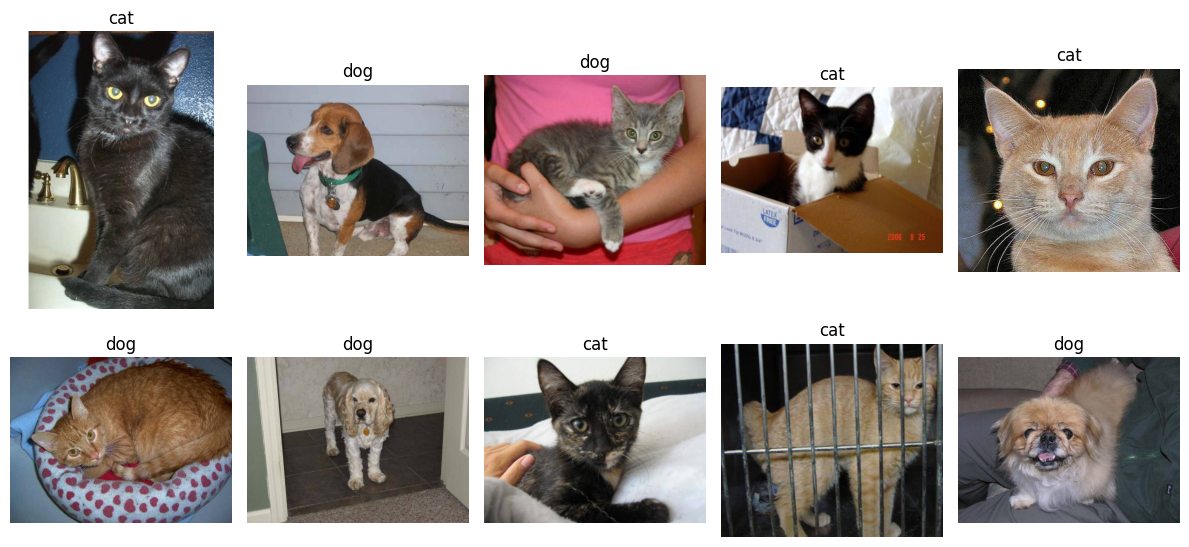

In [52]:
display_image_grid(test_images_filepaths)

In [53]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [54]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [55]:
cat_directory = '/content/drive/MyDrive/24-2/EURON/과제/Week7/dogs-vs-cats/Cat'
dog_directory = '/content/drive/MyDrive/24-2/EURON/과제/Week7/dogs-vs-cats/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
#train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요
#val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [56]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [57]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [58]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [59]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0])


In [60]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [61]:
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [62]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [63]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [64]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [65]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-64-8b28962edeb7>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6934 Acc: 0.4891
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6933 Acc: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4891
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4891
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4891
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.4891
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5700


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.4891
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.4891
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5600


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5000
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5275


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.5761
Training complete in 10m 18s


In [66]:
import pandas as pd

id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv('alexnet.csv', index=False)

<ipython-input-66-ea019e33f897>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
res.head(10)

,id,label
0,145,0.499943
1,211,0.500838
2,162,0.500389
3,200,0.502000
4,210,0.500780
5,224,0.500090
6,213,0.500753
7,109,0.500932
8,15,0.500136
9,167,0.500177


In [68]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

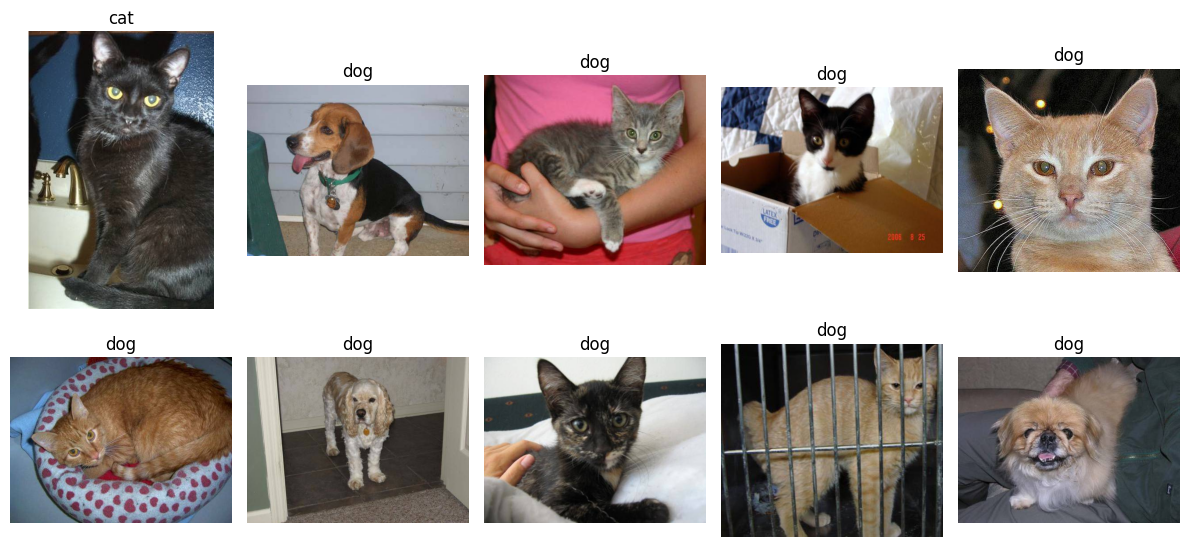

In [69]:
display_image_grid(test_images_filepaths)